In [74]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

import os
from itertools import cycle
from functools import partial
import random
from math import pi

import numpy as np
from sklearn.cluster import KMeans

# Imports for working with shapefiles
import pyproj
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform, cascaded_union
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.colors import to_rgb
from matplotlib import cm
from matplotlib.patches import Polygon
%matplotlib inline

In [3]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

In [4]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [41]:
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': transform(project, shape(block['geometry'])), 
             'geoid': block['properties']['GEOID']
        }
        for block in f
    ]
for block in blocks:
    block['centroid'] = np.array([coord[0] for coord in block['shape'].centroid.xy])

In [46]:
coord_array = np.array([block['centroid'] for block in blocks])

In [77]:
model = KMeans(n_clusters=8, max_iter=10000, n_jobs=-1, tol=1e-9)

In [78]:
labels = model.fit_predict(coord_array)

In [79]:
for label, block in zip(labels, blocks):
    block['label'] = int(label)

In [80]:
districts = [None for i in range(8)]
for label in range(8):
    districts[label] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])

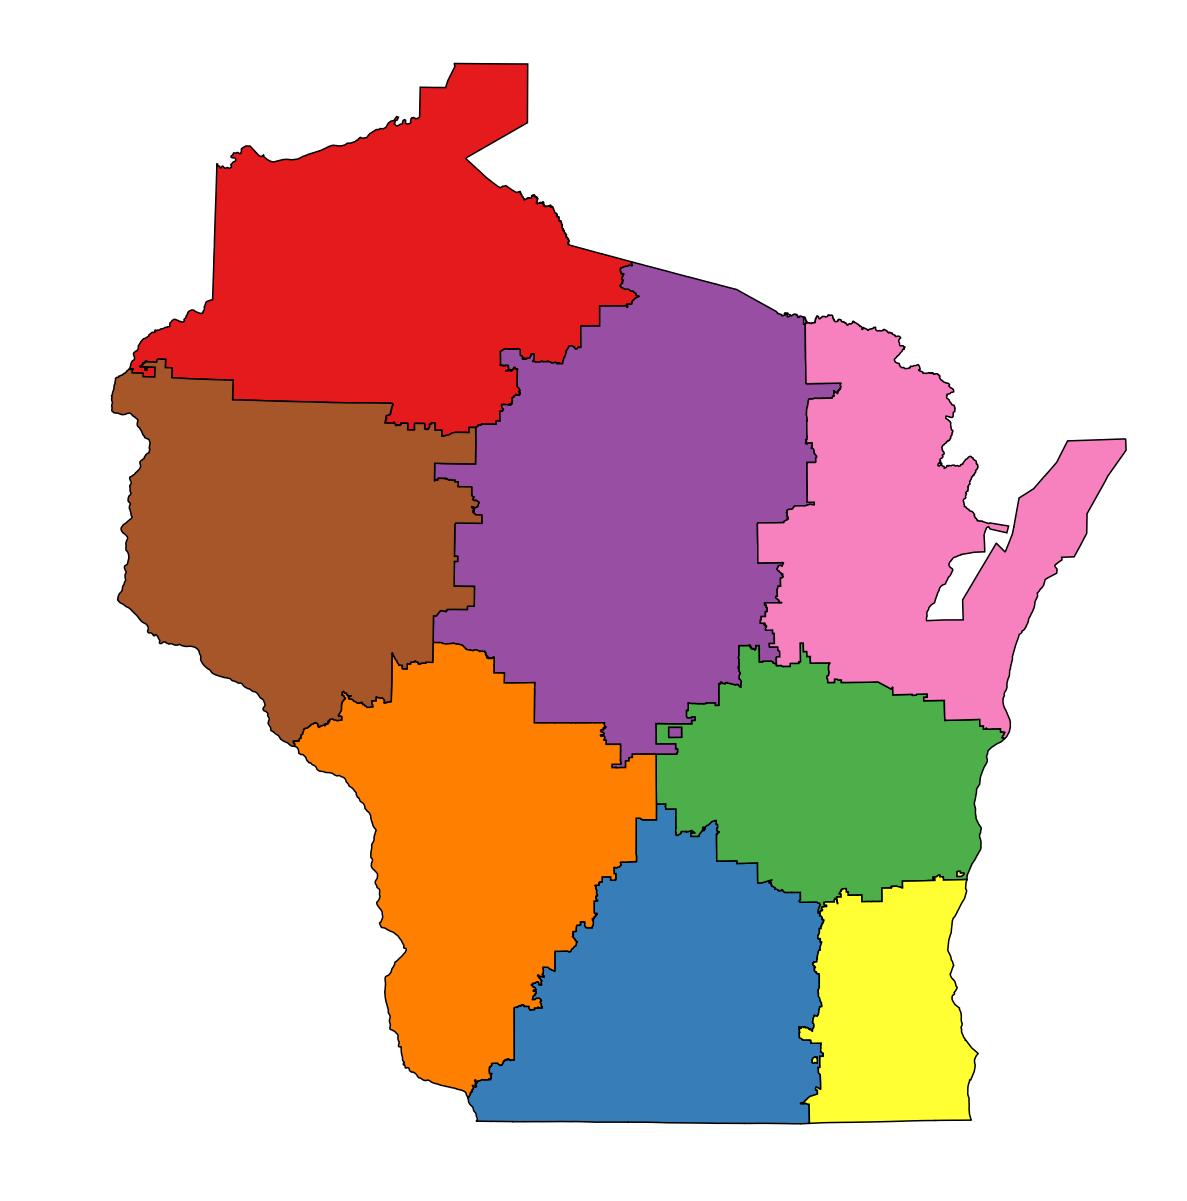

In [81]:
district_patches = [
    PolygonPatch(district)
    for district in districts
]

hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
colors = [to_rgb(color) for color in hex_colors]
for patch, color in zip(district_patches, cycle(colors)):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

fig, ax = plt.subplots()

for patch in district_patches:
    ax.add_patch(patch)
    
ax.relim()
ax.autoscale_view()
ax.axis('off')
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
aspect_ratio = (ymax - ymin)/(xmax - xmin)
x_size = 20
fig.set_size_inches((x_size, x_size*aspect_ratio))